In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=Warning)

In [2]:
# 1. library
import torch

find_links = f"https://data.pyg.org/whl/torch-{torch.__version__}.html"

!pip install -q \
    torch-scatter \
    torch-sparse \
    torch-cluster \
    torch-spline-conv \
    torch-geometric \
    -f $find_links

# seed set
torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed(0)
    torch.cuda.manual_seed_all(0)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print("Installation Complete.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 88.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 119.8 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 74.3 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 55.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 32.9 MB/s eta 0:00:0000:01
Installation Complete.


In [3]:
# Cora dataset, papers as nodes and their citations as edges
from torch_geometric.datasets import Planetoid

# Loading Cora dataset
# Graph Data Download by Planetoid
dataset = Planetoid(root="./cora_data", name="Pubmed")
data = dataset[0]

# Print information about the dataset
print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

# Print information about the graph
print(f'\nGraph:')
print('------')
print(f'Training nodes: {sum(data.train_mask).item()}')
print(f'Evaluation nodes: {sum(data.val_mask).item()}')
print(f'Test nodes: {sum(data.test_mask).item()}')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

# The PubMed dataset is a citation network of biomedical publications related to diabetes classification.
# The dataset consists of 19,717 scientific papers and 44,338 citation links (edges) with TF-IDF weighted word vectors.
# Bif dataset

Processing...
Done!


Dataset: Pubmed()
-------------------
Number of graphs: 1
Number of nodes: 19717
Number of features: 500
Number of classes: 3

Graph:
------
Training nodes: 60
Evaluation nodes: 500
Test nodes: 1000
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False


In [4]:
# batche neighbor sampling

from torch_geometric.loader import NeighborLoader
from torch_geometric.utils import to_networkx

# Create batches with neighbor sampling
train_loader = NeighborLoader(
    data, # 
    num_neighbors=[5, 10], # Sample 5 neighbors for the 1st hop, 10 for the 2nd hop
    batch_size=16,  # Number of seed nodes (center nodes) per batchseed nodes : 16 + 80 (5*16) + 800 (80*10)
    input_nodes=data.train_mask, # Only use training nodes as seed nodes
)

# Inspect the created subgraphs (mini-batches)
for i, subgraph in enumerate(train_loader):
    print(f'Subgraph {i}: {subgraph}')

Subgraph 0: Data(x=[395, 500], edge_index=[2, 447], y=[395], train_mask=[395], val_mask=[395], test_mask=[395], n_id=[395], e_id=[447], input_id=[16], batch_size=16)
Subgraph 1: Data(x=[268, 500], edge_index=[2, 312], y=[268], train_mask=[268], val_mask=[268], test_mask=[268], n_id=[268], e_id=[312], input_id=[16], batch_size=16)
Subgraph 2: Data(x=[294, 500], edge_index=[2, 335], y=[294], train_mask=[294], val_mask=[294], test_mask=[294], n_id=[294], e_id=[335], input_id=[16], batch_size=16)
Subgraph 3: Data(x=[189, 500], edge_index=[2, 225], y=[189], train_mask=[189], val_mask=[189], test_mask=[189], n_id=[189], e_id=[225], input_id=[12], batch_size=12)


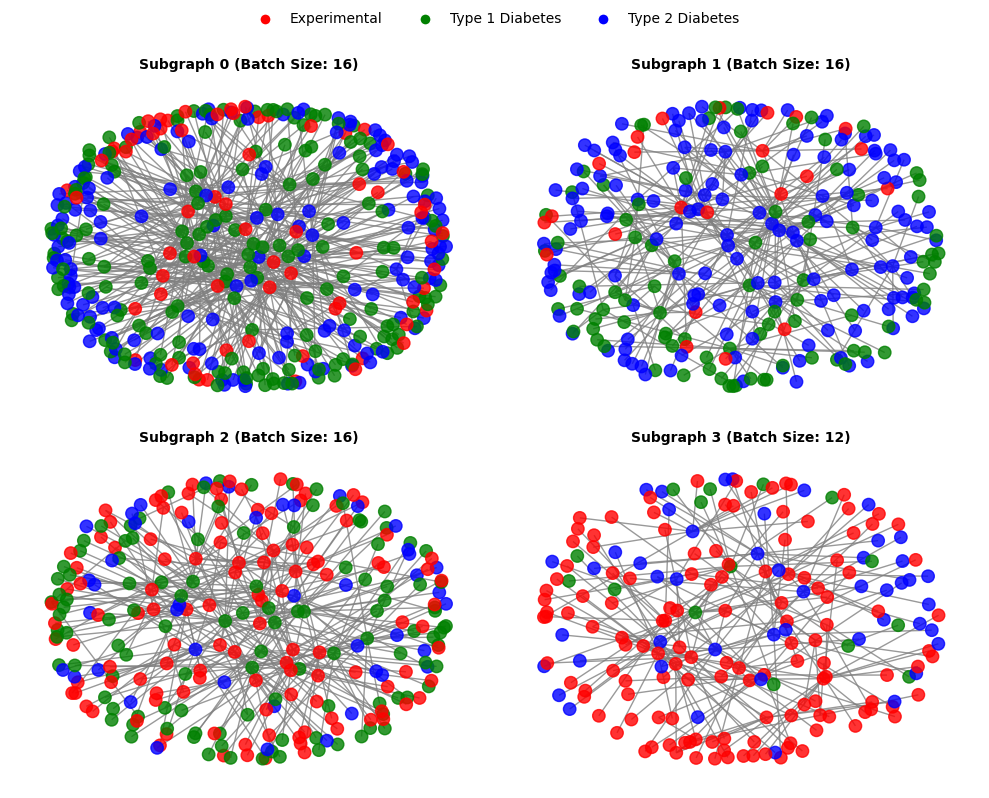

In [5]:
import networkx as nx
from matplotlib.lines import Line2D # Tool for creating custom legends
from matplotlib.colors import ListedColormap # Tool for custom color maps

# 1. Define Class Names (PubMed Standard Mapping)
class_map = {
    0: 'Experimental',    # red
    1: 'Type 1 Diabetes', # green
    2: 'Type 2 Diabetes'  # blue
}

# 2. Visualization Setup
fig = plt.figure(figsize=(10, 8))

# Define custom colors: 0->Red, 1->Green, 2->Blue
custom_colors = ['red', 'green', 'blue']
cmap = ListedColormap(custom_colors)

# 3. Loop to Plot Subgraphs
# Use zip() to plot only the first 4 subgraphs
for idx, (subdata, pos) in enumerate(zip(train_loader, [221, 222, 223, 224])):
    
    # Convert PyG data to NetworkX graph
    G = to_networkx(subdata, to_undirected=True)
    
    # Add subplot
    ax = fig.add_subplot(pos)
    ax.set_title(f'Subgraph {idx} (Batch Size: {subdata.batch_size})', fontsize=10, fontweight='bold')
    plt.axis('off')
    
    # Calculate layout (Fix seed for reproducibility)
    pos_layout = nx.spring_layout(G, seed=1, k=0.5)
    
    # Draw Graph
    # Colors are automatically assigned based on node_color values (0, 1, 2) and the cmap
    nx.draw_networkx(G,
                     pos=pos_layout,
                     with_labels=False,
                     node_color=subdata.y,
                     node_size=80,
                     cmap=cmap,         # Use the custom colormap (Red, Green, Blue)
                     vmin=0, vmax=2,    # Fix the range for classes 0 to 2
                     edge_color='gray',
                     alpha=0.8
                     )

# 4. Create a Unified Legend
# Add a legend at the top to explain what each color represents
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=class_map[0],
           markerfacecolor=custom_colors[0], markersize=8), # Red
    Line2D([0], [0], marker='o', color='w', label=class_map[1],
           markerfacecolor=custom_colors[1], markersize=8), # Green
    Line2D([0], [0], marker='o', color='w', label=class_map[2],
           markerfacecolor=custom_colors[2], markersize=8)  # Blue
]

# Place the legend at the upper center of the figure
fig.legend(handles=legend_elements, loc='upper center', ncol=3, fontsize=10, frameon=False)

plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust layout to make room for the legend
plt.show()

# the massive citation network is sampled into manageable subgraphs.
# The graph shows a high degree of heterophily, where connected nodes often belong to different classes.
# GAT is preferred over GCN as its attention mechanism can filter out irrelevant neighbors, unlike GCN's static averaging.

In [6]:
# Implementation of GraphSAGE model architecture and mini-batch training loop

import torch
torch.manual_seed(1)
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

# 1. Helper function to calculate classification accuracy
def accuracy(pred_y, y):
    return ((pred_y == y).sum() / len(y)).item()

# 2. GraphSAGE Model Definition
class GraphSAGE(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        
        # [Layer 1] First GraphSAGE Convolution Layer
        # Input: dim_in (Number of features) -> Output: dim_h (Hidden dimension)
        # SAGEConv aggregates information from sampled neighbors (mean, max, etc.)
        self.sage1 = SAGEConv(dim_in, dim_h)
        
        # [Layer 2] Second GraphSAGE Convolution Layer
        # Input: dim_h (Hidden dimension) -> Output: dim_out (Number of classes)
        self.sage2 = SAGEConv(dim_h, dim_out)

    def forward(self, x, edge_index):
        # [Step 1] First Aggregation & Transformation
        # Pass input features and connectivity to the first layer
        h = self.sage1(x, edge_index)
        
        # [Step 2] Activation Function (ReLU)
        # Apply non-linearity to the hidden features
        h = torch.relu(h)
        
        # [Step 3] Dropout (Regularization)
        # Randomly zero out 50% of the neurons to prevent overfitting during training
        h = F.dropout(h, p=0.5, training=self.training)
        
        # [Step 4] Second Aggregation (Output Layer)
        # Produce the final output scores (logits) for each class
        h = self.sage2(h, edge_index)
        
        return h

    # 3. Training Loop (Mini-batch Training)
    # Training the model using mini-batches (subgraphs) for scalability
    def fit(self, loader, epochs):
        # Define Loss function (CrossEntropy) and Optimizer (Adam)
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01)

        self.train() # Set model to training mode
        
        for epoch in range(epochs+1):
            total_loss = 0
            acc = 0
            val_loss = 0
            val_acc = 0

            # Iterate over batches (Subgraphs)
            # Unlike GCN/GAT which use the full graph, GraphSAGE iterates through small parts
            for batch in loader:
                optimizer.zero_grad() # Clear gradients
                
                # Forward pass on the subgraph (mini-batch)
                out = self(batch.x, batch.edge_index)
                
                # Calculate Loss only on training nodes within the batch
                loss = criterion(out[batch.train_mask], batch.y[batch.train_mask])
                
                total_loss += loss.item()
                
                # Calculate Accuracy for the batch
                acc += accuracy(out[batch.train_mask].argmax(dim=1), batch.y[batch.train_mask])
                
                # Backward pass & Weight update
                loss.backward()
                optimizer.step()

                # Validation on the batch 
                val_loss += criterion(out[batch.val_mask], batch.y[batch.val_mask])
                val_acc += accuracy(out[batch.val_mask].argmax(dim=1), batch.y[batch.val_mask])

            # Print metrics every 20 epochs
            if epoch % 20 == 0:
                # Calculate average loss and accuracy across all batches
                avg_loss = total_loss / len(loader)
                avg_acc = acc / len(loader)
                avg_val_loss = val_loss / len(loader)
                avg_val_acc = val_acc / len(loader)
                
                print(f'Epoch {epoch:>3} | Train Loss: {avg_loss:.3f} | Train Acc: {avg_acc*100:>6.2f}% | '
                      f'Val Loss: {avg_val_loss:.2f} | Val Acc: {avg_val_acc*100:.2f}%')

    # 4. Evaluation (Inference)
    @torch.no_grad() # Disable gradient calculation
    def test(self, data):
        self.eval() # Set model to evaluation mode
        
        # Forward pass on the full graph (or test batch)
        out = self(data.x, data.edge_index)
        
        # Calculate accuracy on the test set
        acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return acc

In [7]:
# Run the Model

# [Model Instantiation]
# Initialize GraphSAGE model with dataset specifications
# Input: 500 features (PubMed), Hidden: 64 units, Output: 3 classes
graphsage = GraphSAGE(dataset.num_features, 64, dataset.num_classes)
print("\n[Model Structure]")
print(graphsage)

# Training
# Train the model using the NeighborLoader (mini-batches)
print("\n[Starting Training]")
graphsage.fit(train_loader, 200)

# Testing
# Evaluate the model on the full graph using the test mask
print("\n[Final Evaluation]")
acc = graphsage.test(data)
print(f'GraphSAGE Test Accuracy: {acc*100:.2f}%')


[Model Structure]
GraphSAGE(
  (sage1): SAGEConv(500, 64, aggr=mean)
  (sage2): SAGEConv(64, 3, aggr=mean)
)

[Starting Training]
Epoch   0 | Train Loss: 1.134 | Train Acc:  21.42% | Val Loss: 1.13 | Val Acc: 10.83%
Epoch  20 | Train Loss: 0.013 | Train Acc: 100.00% | Val Loss: 0.56 | Val Acc: 75.63%
Epoch  40 | Train Loss: 0.003 | Train Acc: 100.00% | Val Loss: 0.59 | Val Acc: 70.62%
Epoch  60 | Train Loss: 0.001 | Train Acc: 100.00% | Val Loss: 0.43 | Val Acc: 73.33%
Epoch  80 | Train Loss: 0.001 | Train Acc: 100.00% | Val Loss: 0.55 | Val Acc: 81.74%
Epoch 100 | Train Loss: 0.001 | Train Acc: 100.00% | Val Loss: 0.43 | Val Acc: 86.81%
Epoch 120 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.46 | Val Acc: 84.38%
Epoch 140 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.79 | Val Acc: 64.85%
Epoch 160 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.64 | Val Acc: 77.29%
Epoch 180 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.55 | Val Acc: 78.94%
Epoch 200

In [8]:
# Inductive Node Classification using GraphSAGE
# Train a GraphSAGE model on a multi-graph dataset using neighbor sampling and evaluate on unseen graphs

import torch
from sklearn.metrics import f1_score
from torch_geometric.datasets import PPI
from torch_geometric.data import Batch
from torch_geometric.loader import DataLoader, NeighborLoader
from torch_geometric.nn import GraphSAGE

# 1. Device Configuration
# Use GPU if available for faster computation.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 2. Data Loading & Preprocessing
# Load the PPI dataset.
# Unlike Cora (single graph), this dataset consists of multiple graphs.
# - Train: 20 graphs
# - Val: 2 graphs
# - Test: 2 graphs
train_dataset = PPI(root=".", split='train')
val_dataset = PPI(root=".", split='val')
test_dataset = PPI(root=".", split='test')

# Merge training graphs into a single large graph (Batch).
# This allows 'NeighborLoader' to sample subgraphs across all training graphs simultaneously.
train_data = Batch.from_data_list(train_dataset)

# Initialize NeighborLoader for the training set.
# - batch_size: Number of seed nodes per batch.
# - num_neighbors: [20, 10] means sampling 20 neighbors at 1-hop and 10 at 2-hop.
# - shuffle: Randomly shuffle data for stochastic gradient descent.
train_loader = NeighborLoader(train_data, batch_size=2048, shuffle=True, num_neighbors=[20, 10], num_workers=2, persistent_workers=True)

# Loaders for validation and testing.
# Since validation/test graphs are relatively small, we load them graph-by-graph (batch_size=2 graphs).
val_loader = DataLoader(val_dataset, batch_size=2)
test_loader = DataLoader(test_dataset, batch_size=2)

# 3. Model Definition
# Initialize GraphSAGE.
# GraphSAGE is suitable for inductive learning (generalizing to unseen nodes/graphs).
model = GraphSAGE(
    in_channels=train_dataset.num_features,  # Input feature dimension
    hidden_channels=512,                     # Hidden layer dimension
    num_layers=2,                            # Number of GNN layers (hops)
    out_channels=train_dataset.num_classes,  # Output dimension (Number of classes)
).to(device)

# 4. Loss & Optimizer
# - Loss: BCEWithLogitsLoss (Binary Cross Entropy) is used for multi-label classification.
# - Optimizer: Adam optimizer.
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

# 5. Training Function
def fit(loader):
    model.train() # Set model to training mode

    total_loss = 0
    for data in loader:
        data = data.to(device) # Move batch to device
        optimizer.zero_grad()  # Reset gradients
        
        # Forward pass: Compute node embeddings and predictions
        out = model(data.x, data.edge_index)
        
        # Calculate loss
        loss = criterion(out, data.y)
        
        # Backward pass & Optimization
        total_loss += loss.item() * data.num_graphs # Aggregate loss weighted by graph count
        loss.backward()
        optimizer.step()
        
    # Return average loss
    return total_loss / len(loader.data)

# 6. Evaluation Function
@torch.no_grad() # Disable gradient calculation for inference
def test(loader):
    model.eval() # Set model to evaluation mode

    # Iterate through graphs in the loader (Validation/Test set)
    # Note: 'next(iter(loader))' gets the first batch. For full evaluation, a loop is needed.
    data = next(iter(loader)) 
    
    # Predict on the full graph
    out = model(data.x.to(device), data.edge_index.to(device))
    
    # Convert logits to binary predictions (Threshold = 0)
    preds = (out > 0).float().cpu()

    y, pred = data.y.numpy(), preds.numpy()
    
    # Calculate Micro F1-score (Standard metric for multi-label classification)
    return f1_score(y, pred, average='micro') if pred.sum() > 0 else 0

# 7. Execution Loop
print("Starting Inductive GraphSAGE Training...")

for epoch in range(301):
    loss = fit(train_loader)
    val_f1 = test(val_loader) # Evaluate on validation set
    
    if epoch % 50 == 0:
        print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Val F1-score: {val_f1:.4f}')

# Final evaluation on the test set (Unseen data)
print(f'Test F1-score: {test(test_loader):.4f}')

Extracting ./ppi.zip
Processing...
Done!


Starting Inductive GraphSAGE Training...
Epoch   0 | Train Loss: 12.733 | Val F1-score: 0.4849
Epoch  50 | Train Loss: 8.729 | Val F1-score: 0.7988
Epoch 100 | Train Loss: 8.609 | Val F1-score: 0.8131
Epoch 150 | Train Loss: 8.533 | Val F1-score: 0.8140
Epoch 200 | Train Loss: 8.487 | Val F1-score: 0.8240
Epoch 250 | Train Loss: 8.460 | Val F1-score: 0.8247
Epoch 300 | Train Loss: 8.435 | Val F1-score: 0.8284
Test F1-score: 0.8520
